<a href="https://colab.research.google.com/github/JaeDoo1034/-/blob/main/%EB%94%A5%EB%9F%AC%EB%8B%9D_%ED%99%80%EB%A1%9C%EC%84%9C%EA%B8%B0___%EC%97%B0%EC%8A%B5_1%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
!pip install -q torch==1.8.1 torchvision

In [16]:
!pip install --upgrade torchvision==0.9.1

Requirement already up-to-date: torchvision==0.9.1 in /usr/local/lib/python3.7/dist-packages (0.9.1)


In [1]:
!pip uninstall torch torchvision -y
!pip install torch torchvision

Uninstalling torch-1.8.1:
  Successfully uninstalled torch-1.8.1
Uninstalling torchvision-0.9.1:
  Successfully uninstalled torchvision-0.9.1
  Using cached https://files.pythonhosted.org/packages/56/74/6fc9dee50f7c93d6b7d9644554bdc9692f3023fa5d1de779666e6bf8ae76/torch-1.8.1-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/93/8a/82062a33b5eb7f696bf23f8ccf04bf6fc81d1a4972740fb21c2569ada0a6/torchvision-0.9.1-cp37-cp37m-manylinux1_x86_64.whl


https://discuss.pytorch.org/t/v1-6-cuda-compatibility-issue-on-google-colab/90893/6 
에서 오류 해결

In [3]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
# cf) iteration : 파라미터가 1번 업데이트 되는 것을 iterator라고 부른다.
# EX) 데이터 10만개.. 한번에 다 계산하고 grad구하면 RAM에 10만번의 계산값이 올라감.. 부족할 수 있음.
# 한번에 10만개를 다 할 수 없으니까, 100개씩 끊어서 학습함. 1 Chunk를 Batch 혹은 Mini Batch 라고 부름. 그래서 1Batch를 돌리고 grad, cost값을 구하고, gradient값을 update한 게 iterator!
# EX) 데이터 10,000개, Batch size = 100 , Batch 100개,, 100번의 iteration을 돌면 1 epoch!


#참고자료 : <br>
https://greeksharifa.github.io/pytorch/2018/11/10/pytorch-usage-03-How-to-Use-PyTorch/#torchvisiontransforms

In [12]:
batch_size = 128
train_dataset = datasets.MNIST('./data', train = True, download = True,
                               transform = transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.1307,),(0.3081)) 
                                                        ]))

test_dataset = datasets.MNIST('./data', train= False, download = True,
                              transform = transforms.Compose([
                                                              transforms.ToTensor(),
                                                              transforms.Normalize((0.1307),(0.3081,))

                              ]))

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset,[50000,10000])
print("Train : {}, Val : {} Test : {}".format(len(train_dataset),len(val_dataset),len(test_dataset)))

train_loader = torch.utils.data.DataLoader(train_dataset,batch_size = 128, shuffle = True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = 128,shuffle = False)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size = 128,shuffle = False)

Train : 50000, Val : 10000 Test : 10000


## inspect Data

In [21]:
examples = enumerate(train_loader)
batch_idx , (example_data, example_targets) = next(examples)

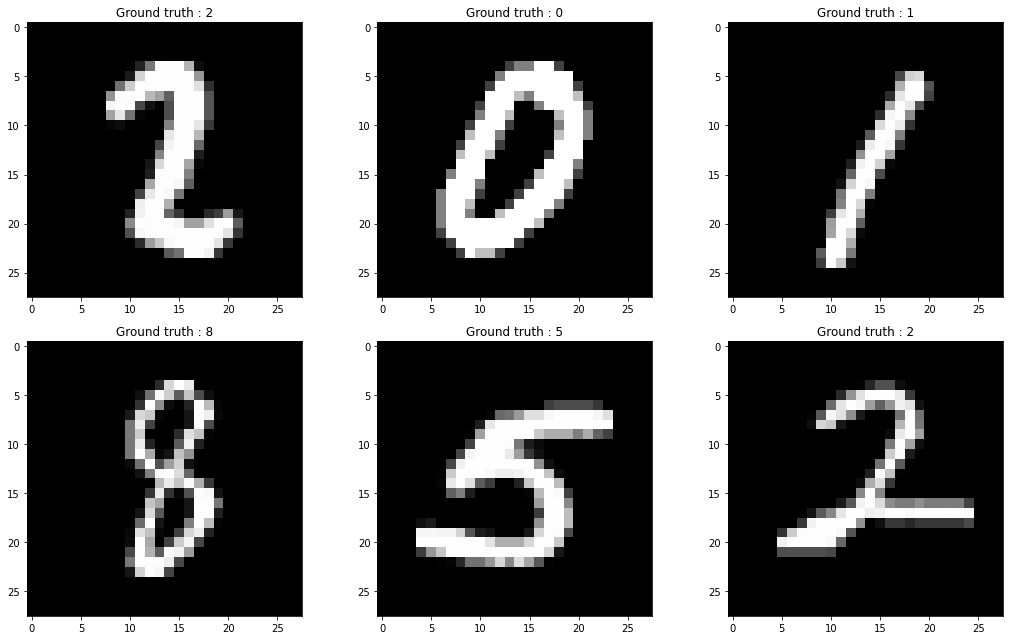

In [26]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (15,9))
for i in range(6):
  plt.subplot(2,3, i + 1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap = 'gray', interpolation = 'none')
  plt.title("Ground truth : {}".format(example_targets[i]))
plt.show()

## Model ACrchitecture

In [88]:
layer = [784,] + [1,2,3,4,5] + [10,]
layer

[784, 1, 2, 3, 4, 5, 10]

In [121]:
# 3개 정도 쌓아보자
class LinearModel(nn.Module):
  def __init__(self,hidden_nodes):
    super().__init__()
    layers = [784,] + hidden_nodes + [10,]
    print(layers)
    self.depth = len(layers) 
    self.nodes = nn.ModuleList([nn.Linear(layers[i],layers[i+1],bias = True) for i in range(self.depth-2)])
    print(self.nodes)
    print(layers[-2])
    self.relu = nn.ReLU()
    self.linear = nn.Linear(layers[-2],10, bias = True)
  
  def forward(self,x):
    for linear in self.nodes:
      x = linear(x)
      x  = self.relu(x)
    x = self.linear(x)
    return x
    

In [122]:
cls_loss= nn.CrossEntropyLoss()

In [123]:
import torch.optim as optim
from sklearn.metrics import accuracy_score

In [129]:
# ===== Model Construct ====== # 
model = LinearModel([1024, 512, 256])
print("Number of {} parameters".format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

[784, 1024, 512, 256, 10]
ModuleList(
  (0): Linear(in_features=784, out_features=1024, bias=True)
  (1): Linear(in_features=1024, out_features=512, bias=True)
  (2): Linear(in_features=512, out_features=256, bias=True)
)
256
Number of 1462538 parameters


In [135]:
Temp = list(train_loader)[0]
print(len(Temp[0]), len(Temp[1]))

128 128


In [140]:
print(Temp[0][0].shape, Temp[0][0].squeeze().shape)
# 스퀴즈(Squeeze) - 1인 차원을 제거한다.

torch.Size([1, 28, 28]) torch.Size([28, 28])


In [142]:
# ===== Model Optimizer ====== # 
lr = 0.005
optimizer = optim.SGD(model.parameters(), lr = lr)

list_epoch = []
list_train_loss = []
list_val_loss = []
list_acc = []
list_acc_epoch = []

epoch = 30
for i in range(epoch):
  # Train
  train_loss = 0
  model.train()

  for input_X, true_y in train_loader:
    optimizer.zero_grad()

    input_X = input_X.squeeze()
    input_X = input_X.view(-1,784) # 파이토치 텐서의 뷰(View)는 넘파이에서의 리쉐이프(Reshape)와 같은 역할을 합니다.
    pred_y = model(input_X) # (,1) 불필요한 차원이 생긴다.

    loss = cls_loss(pred_y.squeeze(),true_y)
    loss.backward()
    optimizer.step()
    # train_loss = loss.detach().numpy()
    train_loss += loss.item()
  
  train_loss = train_loss / len(train_loader)
  list_train_loss.append(train_loss)
  list_epoch.append(i)

  # Val

  val_loss = 0
  model.eval()
   # optimizer.zero_grad() [21.01.05 코드 클린업] 아래 torch.no_grad()가 호출되고 Validation 과정에서는 Optimizer를 사용하지 않으므로 굳이 호출될 필요가 없습니다. 
  with torch.no_grad():
    # [21.01.05 코드 클린업] Validation 과정에서 그라디언트가 활용되지 않도록 torch.no_grad() statement 안에서 코드를 실행합니다
    for input_X, true_y in val_loader:
      input_X = input_X.squeeze()
      input_X = input_X.view(-1,784)
      pred_y = model(input_X)

      loss = cls_loss(pred_y.squeeze(),true_y)
      val_loss += loss.item()
    val_loss = val_loss/len(val_loader)
    list_val_loss.append(val_loss)


    # Test
    correct = 0
    model.eval()

    with torch.no_grad():
      for input_X,true_y in test_loader:
        input_X = input_X.squeeze()
        input_X = input_X.view(-1,784)
        pred_y = model(input_X).max(1, keepdim = True)[1].squeeze()
        print(model(input_X).max(1, keepdim = True))
        correct += pred_y.eq(true_y).sum() # eq : Tensor 안에 원소 비교(Boolean)

      acc = correct.numpy() / len(test_loader.dataset)
      list_acc.append(acc)
      list_acc_epoch.append(i)

    print("Epoch : {}, Train Loss : {}, Val Loss : {}, Test Acc : {}%".format(i,train_loss, val_loss, acc*100))


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
        [2],
        [3],
        [9],
        [2],
        [4],
        [5],
        [5],
        [3],
        [7],
        [5],
        [3],
        [1],
        [8],
        [2],
        [2],
        [3],
        [0],
        [2],
        [9],
        [4],
        [9],
        [7],
        [0],
        [7],
        [7],
        [4],
        [9],
        [9],
        [2],
        [5],
        [9],
        [8],
        [3],
        [8],
        [6],
        [7],
        [0],
        [0],
        [1],
        [2],
        [3],
        [4],
        [5],
        [6],
        [7],
        [8],
        [9],
        [0],
        [1],
        [2],
        [3],
        [4],
        [5],
        [6],
        [7],
        [8],
        [9],
        [0],
        [1],
        [2],
        [3],
        [4],
        [5],
        [6],
        [7],
        [8],
        [9],
        [0],
        [0],
        [7],
        [2],
        [6],
        [5],
        [5],
  

Text(0.5, 1.0, 'epoch vs Accuracy')

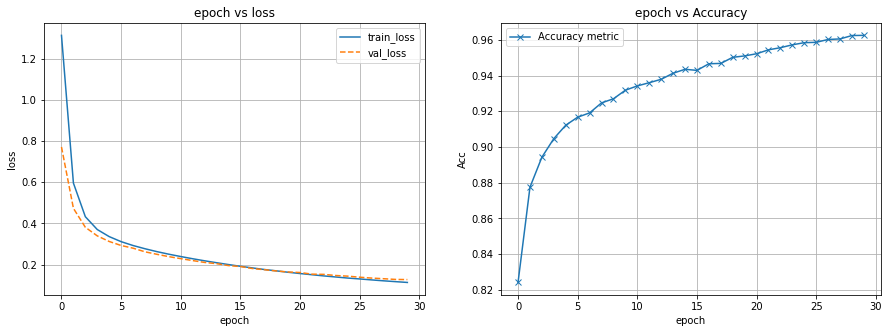

In [143]:

fig = plt.figure(figsize=(15,5))

# ====== Loss Fluctuation ====== #
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(list_epoch, list_train_loss, label='train_loss')
ax1.plot(list_epoch, list_val_loss, '--', label='val_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.grid()
ax1.legend()
ax1.set_title('epoch vs loss')

# ====== Metric Fluctuation ====== #
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(list_acc_epoch, list_acc, marker='x', label='Accuracy metric')
ax2.set_xlabel('epoch')
ax2.set_ylabel('Acc')
ax2.grid()
ax2.legend()
ax2.set_title('epoch vs Accuracy')
